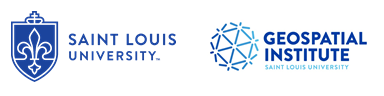

# Assignment 05: Deep Neural Networks in Keras (Part 2A)
## GIS 5092: Applied Machine Learning for GIS and Remote Sensing (Fall 2022)

## Learning Objectives:

* Preprocess geospatial data for LULC classification

# IMPORTANT

## If you are using Google Colab
Whenever you want to keep a copy of this notebook, remember to sign in with your appropriate google account (SLU Google Account is suggested), and save a copy of it in your preferred Google Drive location (preferable location is a seperate folder in your Google Drive for seperate projects, also avoid spaces in folder/file names). Remember to utilize GPU runtime (if needs to use keras). Also remember to pip install necessary packages in every runtime (if needed).

## If you are using Jupyter Notebook
Remember to activate your necessary environment before running codes. Only use Jupyter Notebooks if you are in the lab. If you don't have a GPU machine, then Colab free GPU is suggested.

# How to submit?
Write your answers in code cells with necessary comments. Save a copy of this notebook in your Google Drive / Local Drive by replacing the STUDENT with your SURNAME in CAPS. Upload the completed notebook(s) in Canvas.



---



---



# Data

The dataset for Lab 5 is similar to what you used in Lab 3. Go to the <code>data</code> directory where you will find the following datasets:
```
-- data
  -- Sentinel2B_N0212R126_20190625.tif
  -- lulc_ground_truth.shp
```

The Sentinel 2B imagery was a scene near the Saint Louis City and East Saint Louis region collected on June 25th of 2019. The following map shows the data extent and a snippet of each bands:


assignment5_map.png

Here is a more detailed information on what each band represents in the order:
1. Index 0 - Band 2 - Blue - 490 nm
2. Index 1 - Band 3 - Green - 560 nm
3. Index 2 - Band 4 - Red - 665 nm
4. Index 3 - Band 5 - Red Edge 1 - 705 nm
5. Index 4 - Band 6 - Red Edge 2 - 740 nm
6. Index 5 - Band 7 - Red Edge 3 - 783 nm
7. Index 6 - Band 8 - NIR - 842 nm
8. Index 7 - Band 11 - SWIR 1 - 1610 nm
9. Index 8 - Band 12 - SWIR 2 - 2190 nm

The raster data has 9 bands, each band representing the surface reflectance at that corresponding wavelength (given above). The raster has a 20 m spatial resolution.

Additionally, ground truth data for the LULC has been given in <code>lulc_ground_truth.shp</code> shapefile. The shapefile has 10,000 features (samples/rows) with two unique information, a UID (unique id) and label. It looks like below:

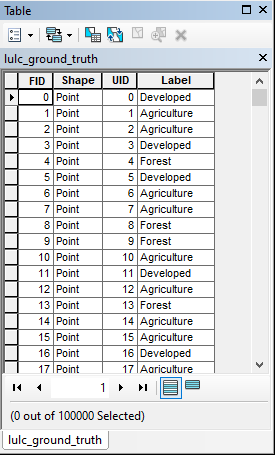

There are total 8 unique classes in the shapefile. The number of samples per class is not uniform.

# Your Tasks

1. Read the raster data using <code>rasterio</code> and shapefile using <code>geopandas</code>.
2. Use the <code>extract_pixel_value_from_point</code> function provided in Lab 3 to get reflectance values for all 9 bands for all 10,000 points.
3. Save the reflectance values as csv in your Google Drive folder (if using colab) or local folder (if using jupyter notebook) for future use.
4. Save the shapefile geopandas dataframe as a csv as well locally. 
5. Answer following questions in a word document (name it *lab_5_Part2A_Answers_SURNAME.docx*): (**Attach the codes you used as well, you can use screenshots**)  
    5.1. What are the unique LULC classes you have in the ground truth data?  
    5.2. How many samples for each class are there in the ground truth data? Create a bar plot of the frequency for each class.


**Important Hints**
- Remember to deal with nodata.
- The sentinel dataset is also stored as 16-bit. So you should divide the reflectance values by the maximum limit of the 16-bit datatype.
- When you are extracting pixel value from point, you should remember to change code wherever necessary. (Bonus Hint: The name of columns will be different here).

# Deliverables
1. The codes for the tasks in thie notebook. (<code>a5_deep_neural_networks_Part2A_STUDENT.ipynb</code>)
2. Two csv files for the extracted reflectance and ground turth data
3. The word document file with answers (<code>lab_5_Part2A_Answers_SURNAME.docx</code>)



---



---



# Your Turn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/lab 5')
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import rasterio
src = rasterio.open('data/Sentinel2B_N0212R126_20190625.tif')
img = src.read()

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

points = gpd.read_file('data/lulc_ground_truth.shp')

100000


In [ ]:
# Convert to float
img = img.astype(float) 
# Convert nodata to np.nan
img[img == 0] = np.nan

In [ ]:
points

UID        Label                        geometry
0          0    Developed  POINT (303242.326 4213611.454)
1          1  Agriculture  POINT (292930.348 4296054.513)
2          2  Agriculture  POINT (265203.800 4269581.511)
3          3    Developed  POINT (238300.425 4296996.469)
4          4       Forest  POINT (304097.171 4211128.006)
...      ...          ...                             ...
99995  99995  Agriculture  POINT (239809.033 4262490.196)
99996  99996  Agriculture  POINT (275318.089 4217774.322)
99997  99997  Agriculture  POINT (240998.394 4257075.880)
99998  99998        Water  POINT (250105.713 4198845.182)
99999  99999  Agriculture  POINT (208582.992 4251397.536)

[100000 rows x 3 columns]

In [ ]:
#Divide by maximum limit of 16-bit
img = img/35536

In [ ]:
def extract_pixel_value_from_point(point_shape, image_src, image_np):
    
    """
    Extracts the pixel value(s) from a given point shapefile and
    a numpy geospatial image.
    
    Arguments:
        - point_shape: A geopandas dataframe containing the point
            feature. It must have a UID specified which indicates
            an unique ID.
        - image_src: A rasterio source. The reference system of
            both shapefile and image has to match with each other.
        - image_np: A np.ndarray version of the rasterio image.
            The array should be free from nodata values.
    
    Returns:
        - values_df: A pandas dataframe containing the UID and
            associated pixel value(s).
    """
    
    # Empty dictionary to hold all the pixel values
    values_dict = {}
    
    # Loop through each point feature and populate the dict
    for i, point in enumerate(point_shape['geometry']):
        
        # Get the x and y coordinate
        x = point.xy[0][0]
        y = point.xy[1][0]
        
        # Get the associated row col number
        # based on the coordinate
        row, col = image_src.index(x, y)
        values = image_np[:, row, col]
        
        # Get the UID
        uid = point_shape.iloc[i, 0]
        
        # Populate the dictionary
        values_dict[uid] = values
        
    # Convert the dictionary to a pd dataframe
    values_df = pd.DataFrame(values_dict).T
    # Reset the index of the df
    values_df.reset_index(inplace=True)
    # Change the column names
    values_df.columns = ['UID', 'Blue', 'Green', 'Red', 'Red Edge 1', 'Red Edge 2', 'Red Edge 3', 
                         'NIR', 'SWIR 1', 'SWIR 2']
    
    return values_df

# Apply the function
reflectance = extract_pixel_value_from_point(points, src, img)
reflectance

UID      Blue     Green       Red  Red Edge 1  Red Edge 2  \
0          0  0.019811  0.026649  0.023891    0.036442    0.072743   
1          1  0.018713  0.027296  0.027859    0.042098    0.060474   
2          2  0.023131  0.029688  0.039566    0.048880    0.055324   
3          3  0.013423  0.022597  0.026086    0.041704    0.084309   
4          4  0.003630  0.007570  0.003658    0.015224    0.073644   
...      ...       ...       ...       ...         ...         ...   
99995  99995  0.020317  0.027268  0.036020    0.046910    0.053382   
99996  99996  0.017475  0.024145  0.033431    0.041845    0.049752   
99997  99997  0.022034  0.029322  0.038975    0.047389    0.056956   
99998  99998  0.013451  0.018798  0.023357    0.024989    0.015562   
99999  99999  0.004587  0.005825  0.002336    0.003968    0.000704   

       Red Edge 3       NIR    SWIR 1    SWIR 2  
0        0.088783  0.098295  0.065764  0.041845  
1        0.068972  0.074769  0.076458  0.049612  
2        0.060558  0.070014  0.101840  0.075163  
3        0.098520  0.103810  0.066383  0.036667  
4        0.100321  0.108397  0.049893  0.021021  
...           ...       ...       ...       ...  
99995    0.061234  0.069141  0.101418  0.076261  
99996    0.054958  0.062922  0.072377  0.048205  
99997    0.061206  0.069507  0.080594  0.058757  
99998    0.015252  0.010750  0.001379  0.001660  
99999    0.001463  0.000816  0.000900  0.000591  

[100000 rows x 10 columns]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = reflectance.join(points, on='UID', rsuffix='_')
data

UID      Blue     Green       Red  Red Edge 1  Red Edge 2  \
0          0  0.019811  0.026649  0.023891    0.036442    0.072743   
1          1  0.018713  0.027296  0.027859    0.042098    0.060474   
2          2  0.023131  0.029688  0.039566    0.048880    0.055324   
3          3  0.013423  0.022597  0.026086    0.041704    0.084309   
4          4  0.003630  0.007570  0.003658    0.015224    0.073644   
...      ...       ...       ...       ...         ...         ...   
99995  99995  0.020317  0.027268  0.036020    0.046910    0.053382   
99996  99996  0.017475  0.024145  0.033431    0.041845    0.049752   
99997  99997  0.022034  0.029322  0.038975    0.047389    0.056956   
99998  99998  0.013451  0.018798  0.023357    0.024989    0.015562   
99999  99999  0.004587  0.005825  0.002336    0.003968    0.000704   

       Red Edge 3       NIR    SWIR 1    SWIR 2   UID_        Label  \
0        0.088783  0.098295  0.065764  0.041845      0    Developed   
1        0.068972  0.074769  0.076458  0.049612      1  Agriculture   
2        0.060558  0.070014  0.101840  0.075163      2  Agriculture   
3        0.098520  0.103810  0.066383  0.036667      3    Developed   
4        0.100321  0.108397  0.049893  0.021021      4       Forest   
...           ...       ...       ...       ...    ...          ...   
99995    0.061234  0.069141  0.101418  0.076261  99995  Agriculture   
99996    0.054958  0.062922  0.072377  0.048205  99996  Agriculture   
99997    0.061206  0.069507  0.080594  0.058757  99997  Agriculture   
99998    0.015252  0.010750  0.001379  0.001660  99998        Water   
99999    0.001463  0.000816  0.000900  0.000591  99999  Agriculture   

                             geometry  
0      POINT (303242.326 4213611.454)  
1      POINT (292930.348 4296054.513)  
2      POINT (265203.800 4269581.511)  
3      POINT (238300.425 4296996.469)  
4      POINT (304097.171 4211128.006)  
...                               ...  
99995  POINT (239809.033 4262490.196)  
99996  POINT (275318.089 4217774.322)  
99997  POINT (240998.394 4257075.880)  
99998  POINT (250105.713 4198845.182)  
99999  POINT (208582.992 4251397.536)  

[100000 rows x 13 columns]

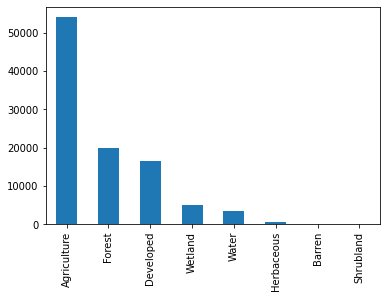

In [ ]:
counts = data['Label'].value_counts()
counts.plot.bar(x = 'Label', y = 'val')

plt.show()

In [ ]:
data['Label'].value_counts()

Agriculture    54035
Forest         20070
Developed      16513
Wetland         5040
Water           3399
Herbaceous       592
Barren           233
Shrubland        118
Name: Label, dtype: int64

In [ ]:
reflectance.to_csv('D:\Assignment5_Barth\lab5\reflectance_values.csv')  
points.to_csv('D:\Assignment5_Barth\lab5\shapefile.csv')